<a href="https://colab.research.google.com/github/Sergio-Rodriguez24/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediction of Product Sales

<H7>Sergio Rodriguez</H7>



## Project Overview


##Imports


In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

## EDA fuctions

In [ ]:
## Set MatPlotLib default parameters
plt.rcParams.update({'figure.facecolor': 'white',
                          'font.weight': 'bold',
                      'patch.linewidth': 1.25,
                       'axes.facecolor': 'white',
                       'axes.edgecolor': 'black',
                       'axes.linewidth': 2,
                       'axes.titlesize': 12,
                     'axes.titleweight': 'bold',
                       'axes.labelsize': 12,
                     'axes.labelweight': 'bold',
                      'xtick.labelsize': 10,
                      'ytick.labelsize': 10,
                            'axes.grid': True,
                       'axes.grid.axis': 'y',
                           'grid.color': 'black',
                       'grid.linewidth': .5,
                           'grid.alpha': .25,
                   'scatter.edgecolors': 'black'})

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

"""UNIVARIATE PLOTTING FUNCTIONS FOR EDA"""
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


# TO DO: add the new print statements from explore_categorical
def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

In [ ]:
"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='rating',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y='Item_Outlet_Sales',
                           figsize=(6,4),
                           ):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

## Load and Inspect Data


In [ ]:
#import sale prediction
df_sp = pd.read_csv('/content/drive/MyDrive/CodingDojo data import/01-Fundamentals/Week02/Data/sales_predictions_2023.csv')

# look at the info with in the DB
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
#preview to make sure import correct
df_sp.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
df_sp.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Data cleaning


In [ ]:
#row/col in df
df_sp.shape

(8523, 12)

In [ ]:
df_sp.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
# of the duplicated rows (including the first)
duplicated_rows_all = df_sp.duplicated(keep=False)
duplicated_rows_all.sum()

0

In [ ]:
#identify missing value
null_sum = df_sp.isna().sum()
null_sum[null_sum>0]

Item_Weight    1463
Outlet_Size    2410
dtype: int64

In [ ]:
#identify % of missing
null_percent = null_sum/len(df_sp) *100
null_percent[null_percent>0]

Item_Weight    17.165317
Outlet_Size    28.276428
dtype: float64

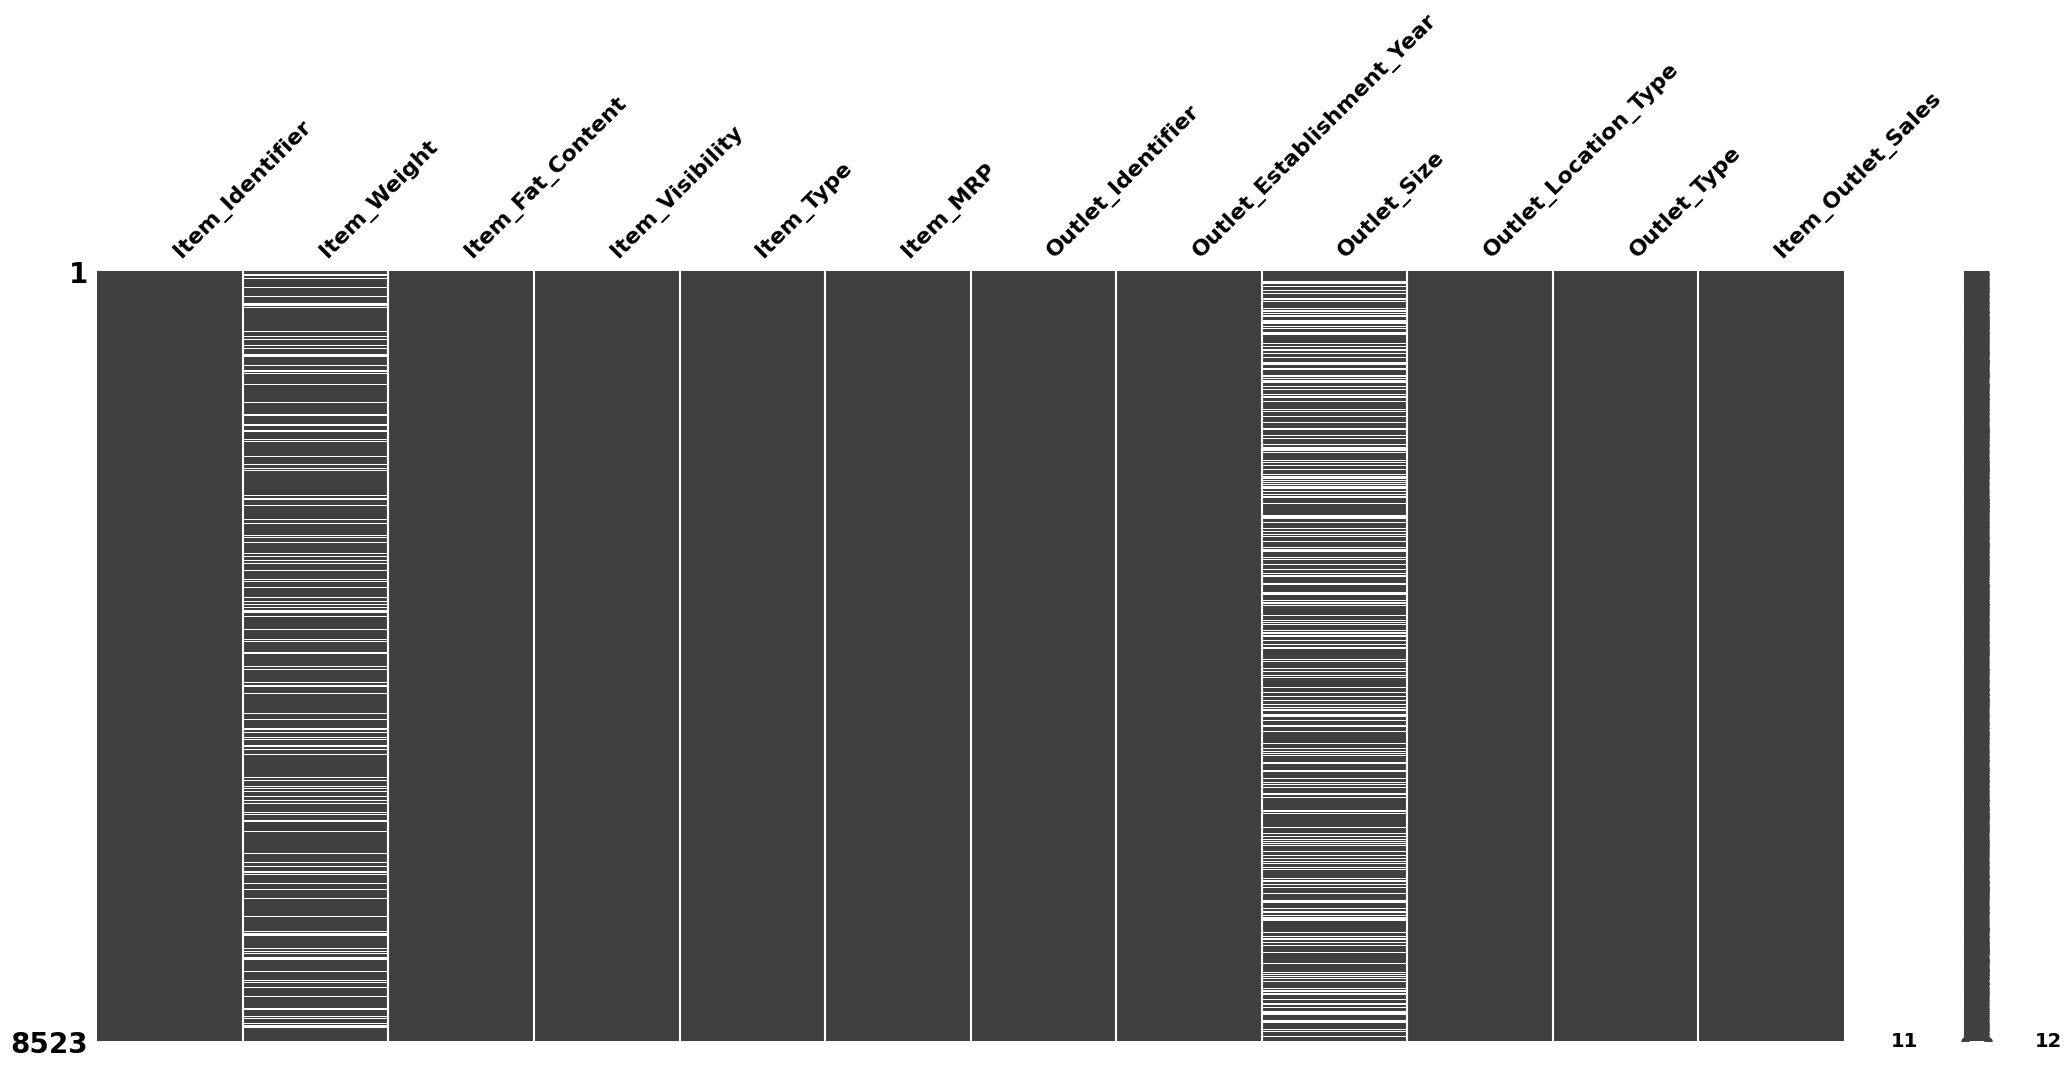

In [ ]:
#Visualizing Null Values with missingno
msno.matrix(df_sp);

In [ ]:
## Looking for missing value in categorial column
cat_col = df_sp.select_dtypes('object').columns
df_sp [cat_col].isna().sum()

Item_Identifier            0
Item_Fat_Content           0
Item_Type                  0
Outlet_Identifier          0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
dtype: int64

In [ ]:
#Place holder value Missing for Outlet_size
df_sp[cat_col] = df_sp[cat_col].fillna('Missing')
#checking
df_sp[cat_col].isna().sum()

Item_Identifier         0
Item_Fat_Content        0
Item_Type               0
Outlet_Identifier       0
Outlet_Size             0
Outlet_Location_Type    0
Outlet_Type             0
dtype: int64

In [ ]:
## Looking for missing value in numerical columns column
num_col = df_sp.select_dtypes('number').columns
df_sp [num_col].isna().sum()

Item_Weight                  1463
Item_Visibility                 0
Item_MRP                        0
Outlet_Establishment_Year       0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
# Create a filter for null values
null_item_weight  =df_sp['Item_Weight'].isna()
# Use the filter to display only the rows with null values in item wieght
df_sp[null_item_weight]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


In [ ]:
# Changing this value to a null value by using np.nan
df_sp.loc[null_item_weight, 'Item_Weight'] = np.nan
#filling value as -1
df_sp['Item_Weight'] = df_sp['Item_Weight'].fillna(-1)
#checkin
df_sp['Item_Weight'].isna().sum()

0

<Axes: >

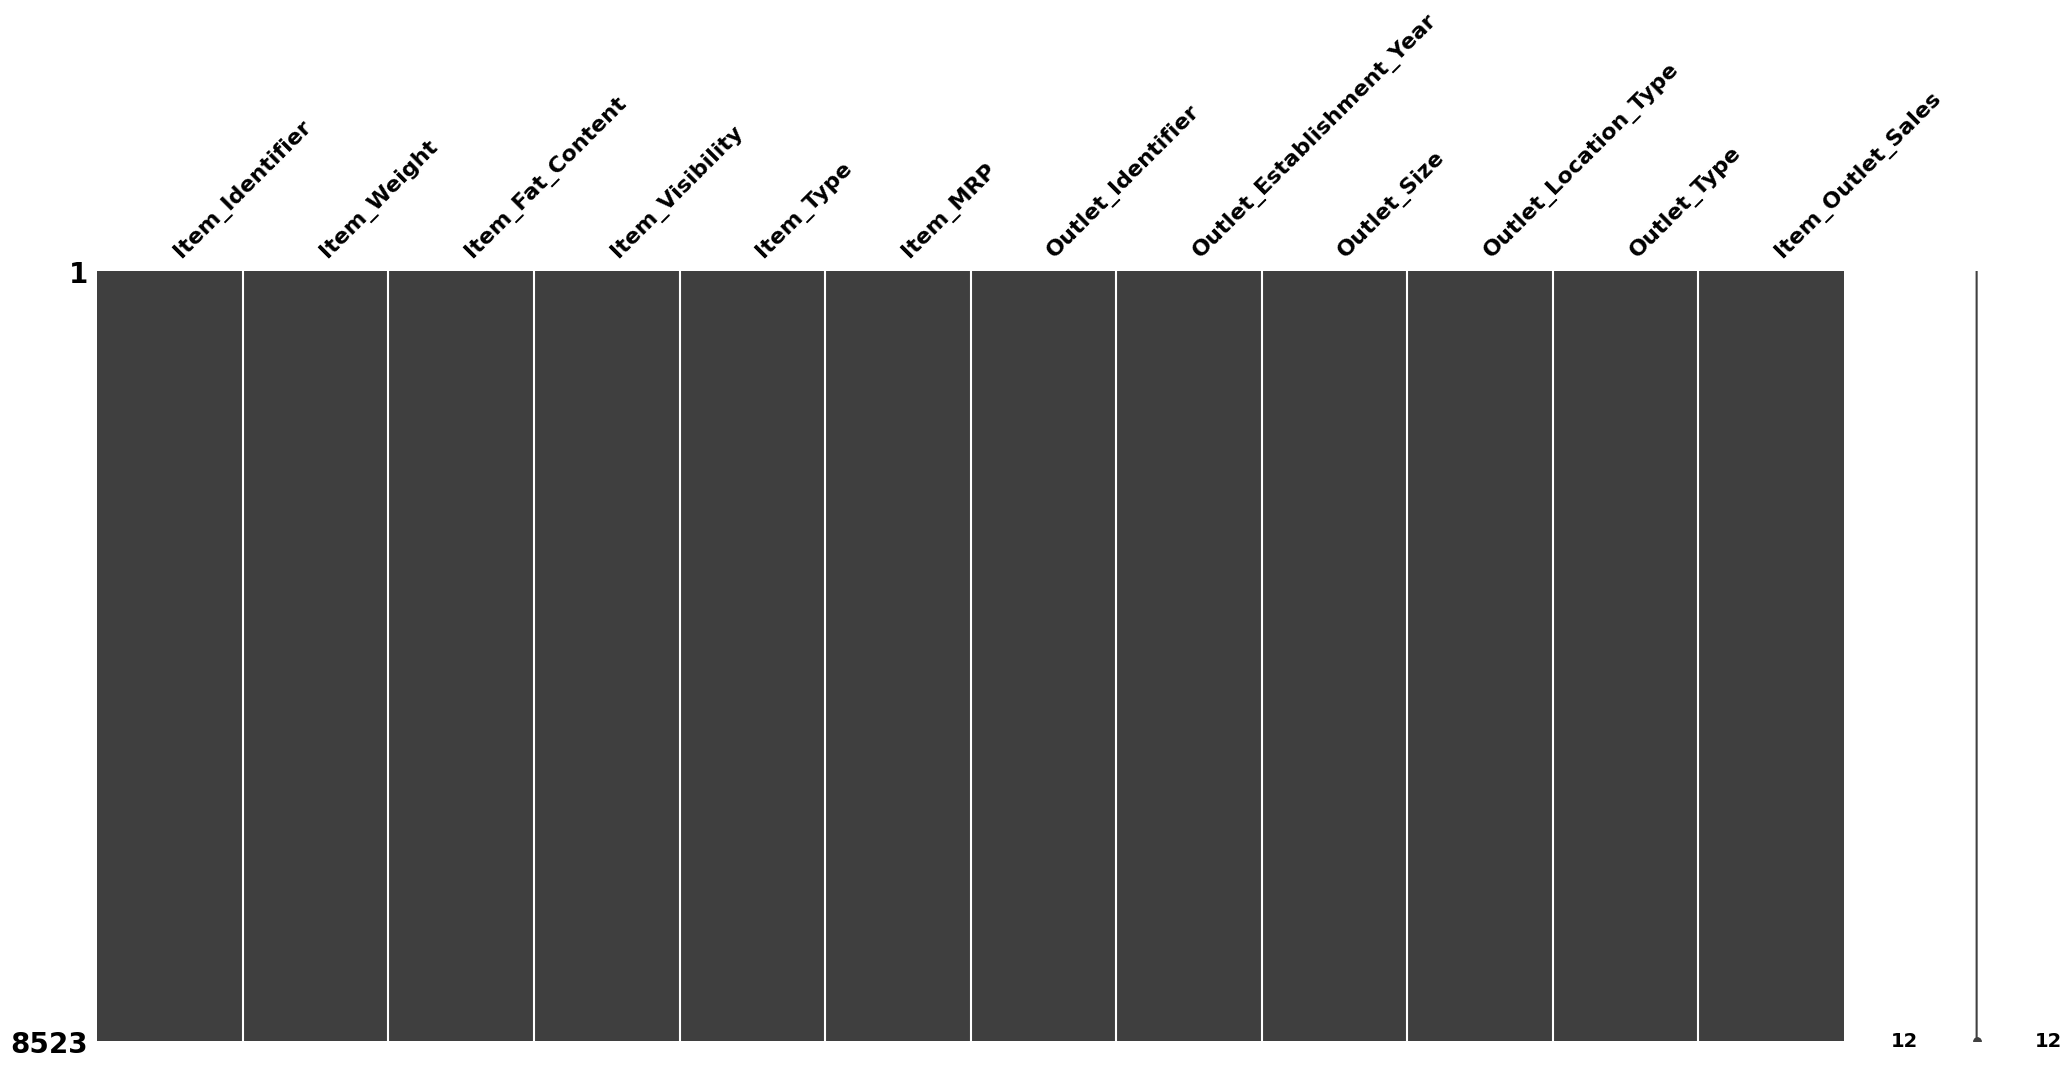

In [ ]:
# Confirm no more nulls using using missingno
msno.matrix(df_sp)

In [ ]:
# Saving list of object columns
incon_col = df_sp.select_dtypes('object').columns
incon_col

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [ ]:
# Checking for  inconsistent
for col in incon_col:
  print(f'Value count for {col}')
  print(df_sp[col].value_counts())
  print('\n')

Value count for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value count for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value count for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value count for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT0

In [ ]:
# Changed Outlet_Size from high to Large to better fit the rest of the naming
df_sp['Outlet_Size'] = df_sp['Outlet_Size'].replace({'High':'Large'})
df_sp['Outlet_Size'].value_counts()

Medium     2793
Missing    2410
Small      2388
Large       932
Name: Outlet_Size, dtype: int64

In [ ]:
# Changed Item_fat names to match
df_sp ['Item_Fat_Content'] =df_sp ['Item_Fat_Content'].replace({'reg': 'Regular', 'LF' :'Low Fat', 'low fat': 'Low Fat'})
df_sp ['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
df_sp.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,10.478936,0.066132,140.992782,1997.831867,2181.288914
std,6.720742,0.051598,62.275067,8.371760,1706.499616
min,-1.000000,0.000000,31.290000,1985.000000,33.290000
25%,6.650000,0.026989,93.826500,1987.000000,834.247400
50%,11.000000,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Exploratory Data Analysis


In [ ]:
#Checking info
# Checking info again
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
## Custom fuction to plot histogram and boxplots
def plot_numeric(df_sp,col):
  fig, axes = plt.subplots(nrows=2, figsize=(8,4),sharex=True)

  sns.histplot(data=df_sp,x = col, ax =axes[0])
  mean_value = df_sp[col].mean()
  axes[0].axvline(mean_value,color='red', ls='--',
           label=f"Mean Value = ${mean_value:,.2f}",);

  med_value = df_sp[col].median()
  axes[0].axvline(med_value,color='g', ls='--',
           label=f"Median Value = ${med_value:,.2f}");

  sns.boxplot(data=df_sp, x = col, ax = axes[1])

  ## Title for each graph
  axes[0].set_title(f'EDA for {col}')


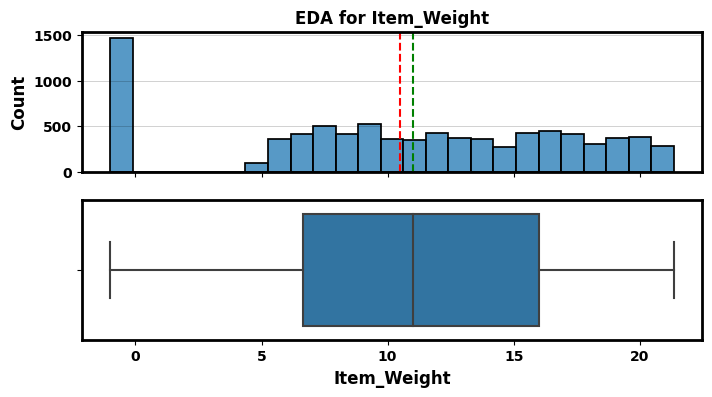

In [ ]:
plot_numeric(df_sp,'Item_Weight')

- The mean is just over 10 for this column even though we have a large amount of items under a pound.

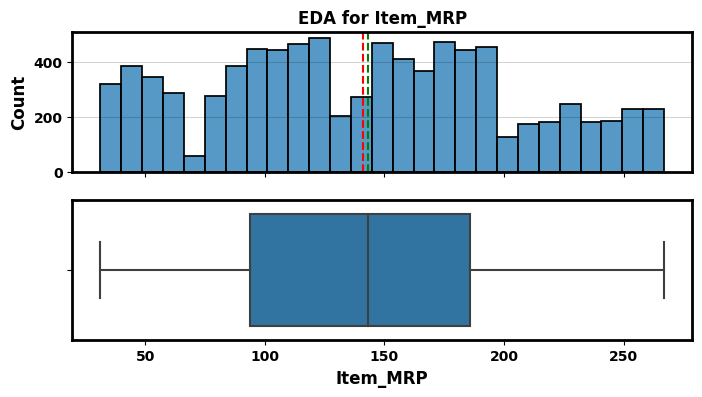

In [ ]:
plot_numeric(df_sp,'Item_MRP')

- Item MRP if a little less than 150

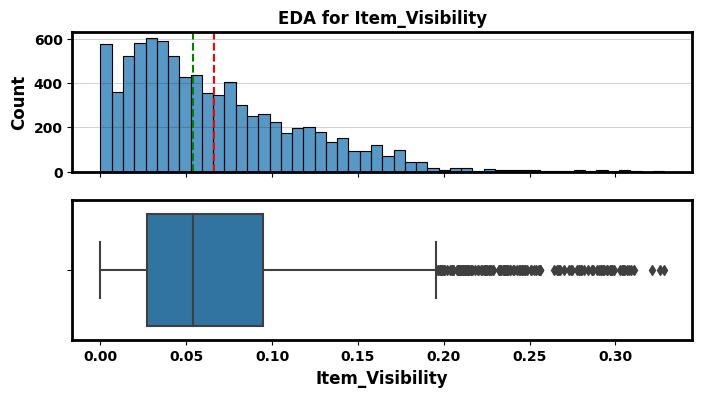

In [ ]:
plot_numeric(df_sp,'Item_Visibility')

- You can clearly see that the median is around .06 per item
- The boxplot shows that there are some outliers in this section. These are most valid with items on display


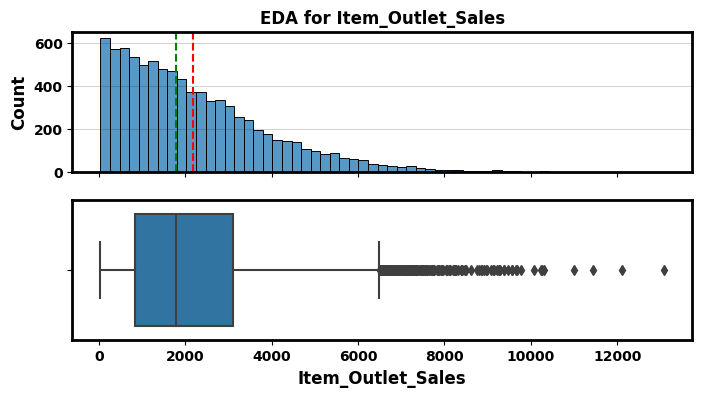

In [ ]:
plot_numeric(df_sp,'Item_Outlet_Sales')

- The mean of Outlet sales lies around 2,000
-The boxplot shows that there are some outliers in this section.

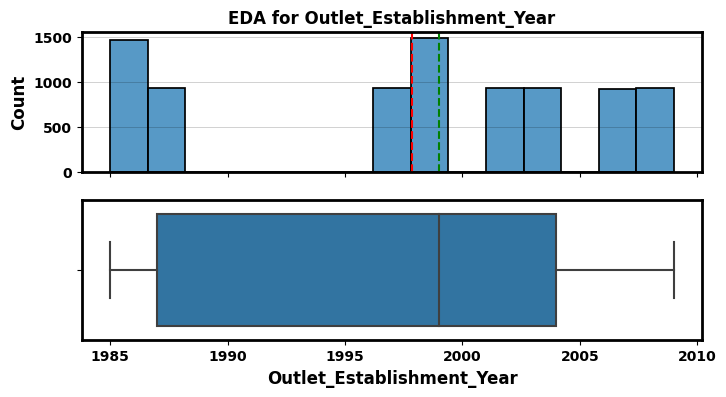

In [ ]:
plot_numeric(df_sp,'Outlet_Establishment_Year')

- We can see a large amount of stores were open 2,000 with stores opening remianing consitent over the years with small gaps in between

In [ ]:
corr=df_sp.corr(numeric_only=True)
corr.round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.00,-0.08,0.02,0.54,-0.06
Item_Visibility,-0.08,1.00,-0.00,-0.07,-0.13
Item_MRP,0.02,-0.00,1.00,0.01,0.57
Outlet_Establishment_Year,0.54,-0.07,0.01,1.00,-0.05
Item_Outlet_Sales,-0.06,-0.13,0.57,-0.05,1.00


Visualizing with Countplots

Did not include Item_Identifier due to haveing so many unique var

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


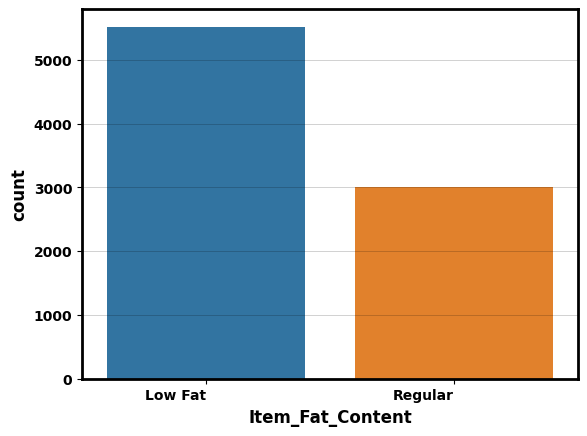

In [ ]:
ax = sns.countplot(data=df_sp, x='Item_Fat_Content')
ax.set_xticklabels(ax.get_xticklabels(), ha='right');
print(df_sp['Item_Fat_Content'].value_counts())

- From this graph, we can see that Low fat make up the majority of milk sales

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


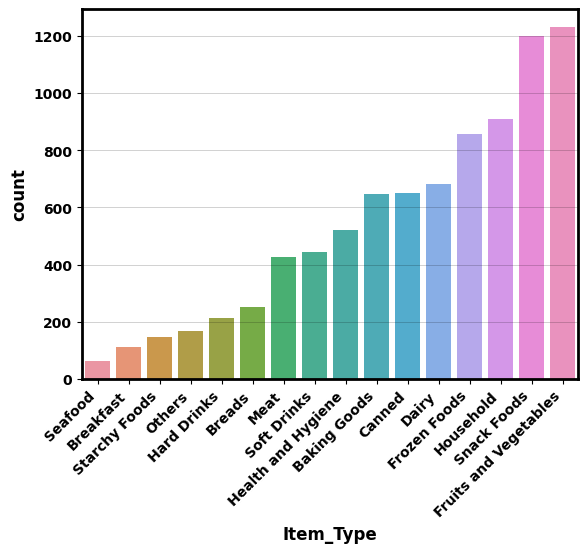

In [ ]:
ax = sns.countplot(data=df_sp, x='Item_Type',order=df_sp['Item_Type'].value_counts(ascending=True).index.value_counts(ascending=True).index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
print(df_sp['Item_Type'].value_counts())

- From this graph, we can see that the top 3 items we have is:
 - Household items
 - Snack food
 - Fruits and Vegteables as number 1

- We can also see the lowest 3 items types would be:
  - Seafood as the lowest followed by
  - Breakfast
  - Starchy Foods

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64


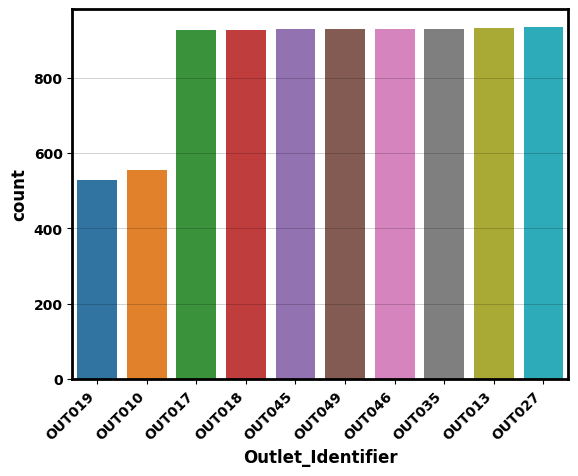

In [ ]:
ax = sns.countplot(data=df_sp, x='Outlet_Identifier',order=df_sp['Outlet_Identifier'].value_counts(ascending=True).index.value_counts(ascending=True).index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
print(df_sp['Outlet_Identifier'].value_counts())

Medium     2793
Missing    2410
Small      2388
Large       932
Name: Outlet_Size, dtype: int64


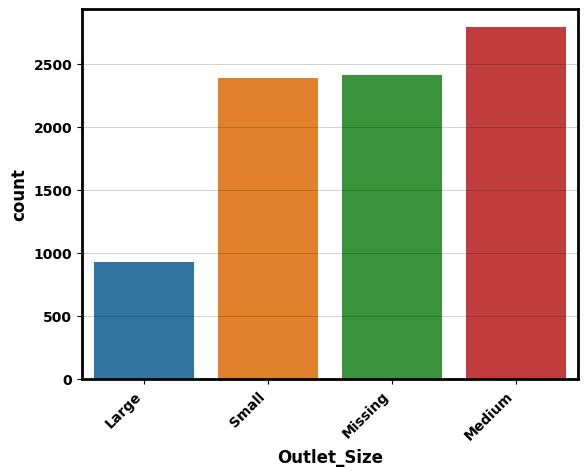

In [ ]:
ax = sns.countplot(data=df_sp, x='Outlet_Size',order=df_sp['Outlet_Size'].value_counts(ascending=True).index.value_counts(ascending=True).index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
print(df_sp['Outlet_Size'].value_counts())

- We are able to see we are missing a large amount of data

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64


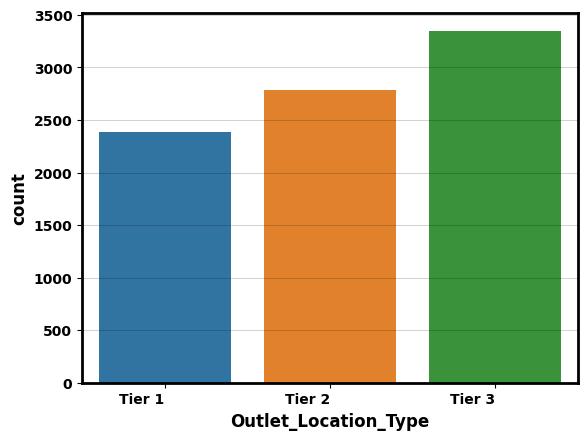

In [ ]:
ax = sns.countplot(data=df_sp, x='Outlet_Location_Type',order=df_sp['Outlet_Location_Type'].value_counts(ascending=True).index.value_counts(ascending=True).index)
ax.set_xticklabels(ax.get_xticklabels(), ha='right');
print(df_sp['Outlet_Location_Type'].value_counts())

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64


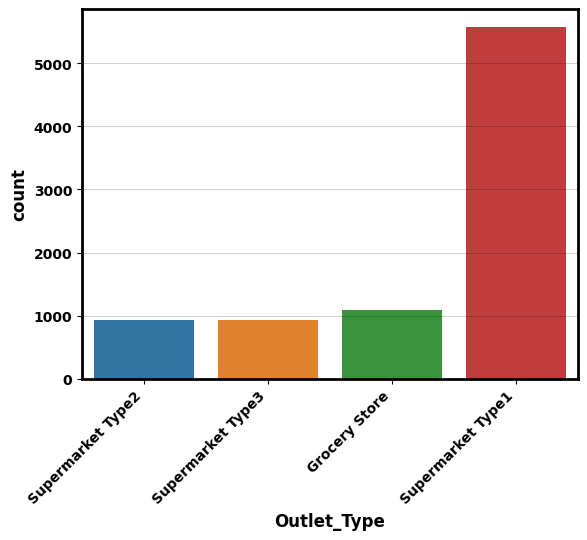

In [ ]:
ax = sns.countplot(data=df_sp, x='Outlet_Type',order=df_sp['Outlet_Type'].value_counts(ascending=True).index.value_counts(ascending=True).index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
print(df_sp['Outlet_Type'].value_counts())

From this graph, we can see that the largest Outlet type would be Supermarket Type 1 with it making up over 50% of the stores

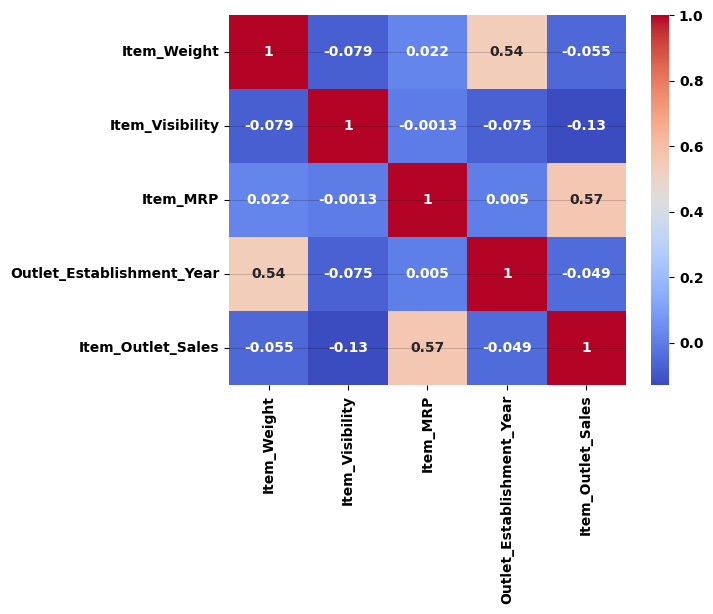

In [ ]:
sns.heatmap(corr, cmap = 'coolwarm', annot = True);


- There is a moderate postive correlation between the Item_MRP and Item_Outlet_slaes
- All of the other correlations are negligible.

### Inspecting Each Feature

- Define your target column:
 - Item_Outlet_Sales

In [ ]:
df_sp.info()
df_sp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Missing,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052


In [ ]:
# Keep ony required columns
use_cols = ['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type','Item_Outlet_Sales']
df_sp = df_sp[use_cols]
df_sp

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228
2,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,Missing,Tier 3,Grocery Store,732.3800
4,8.930,Low Fat,0.000000,Household,53.8614,OUT013,Large,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,Large,Tier 3,Supermarket Type1,2778.3834
8519,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,Missing,Tier 2,Supermarket Type1,549.2850
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,Small,Tier 2,Supermarket Type1,1193.1136
8521,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,Medium,Tier 3,Supermarket Type2,1845.5976


#### Item_Weight                
- Wieght of product

In [ ]:
# Confirming the dtype to select correct EDA function
feature = 'Item_Weight'
df_sp[feature].dtype

dtype('float64')

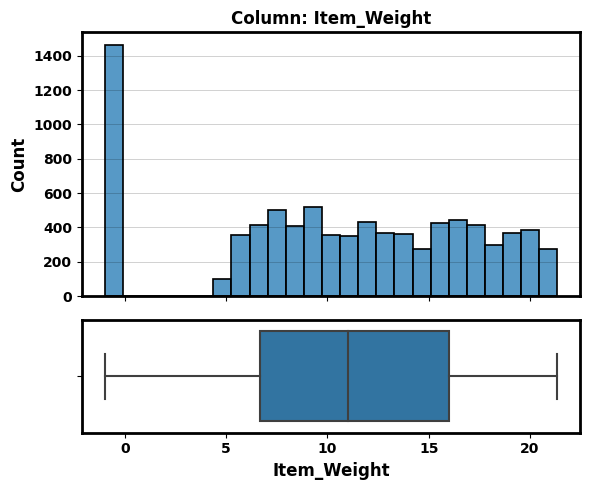

- NaN's Found: 0 (0.0%)
- Unique Values: 416
- Most common value: '-1.0' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


In [ ]:
# run the appropriate explore function (based on feature's dtype)
explore_numeric(df_sp,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 1463 null values.
  - Impute with the median

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No there is to many variables.

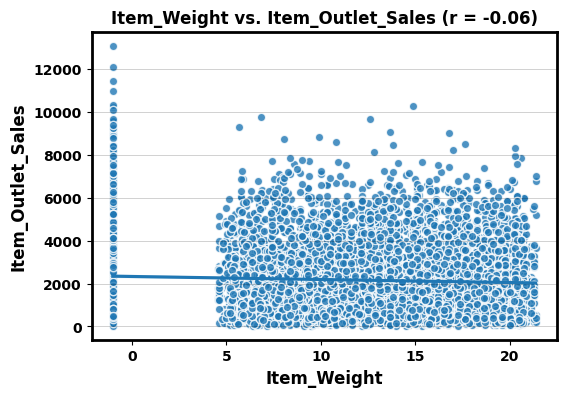

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df_sp, feature, 'Item_Outlet_Sales');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes I would expect having more fiber corresponds with a higher rating.
  - Does this feature appear to be a predictor of the target?
    - negative corr.

___

#### Item_Fat_Content           
- Whether the product is low-fat or regular

In [ ]:
# Confirming the dtype to select correct EDA function
feature = 'Item_Fat_Content'
df_sp[feature].dtype

dtype('O')

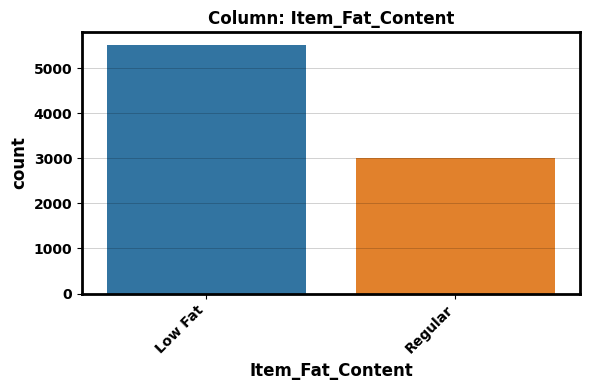

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


In [ ]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df_sp,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 2 is not high.

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

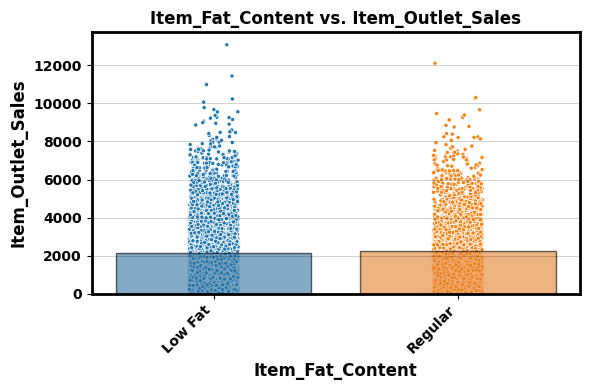

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df_sp, feature, 'Item_Outlet_Sales');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - yes it shows how much profit is generated by sale.
  - Does this feature appear to be a predictor of the target?
    - Yes, regular milk has a higher profit than low fat

___

#### Item_Visibility            
- 	The percentage of total display area of all products in a store allocated to the particular product

In [ ]:
# Confirming the dtype to select correct EDA function
feature = 'Item_Visibility'
df_sp[feature].dtype

dtype('float64')

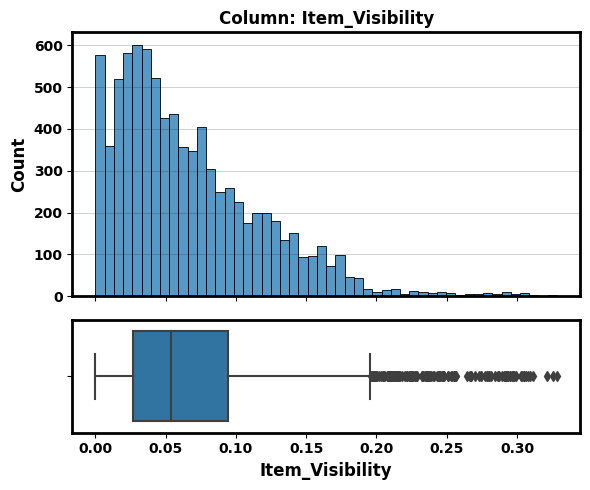

- NaN's Found: 0 (0.0%)
- Unique Values: 7880
- Most common value: '0.0' occurs 526 times (6.17%)
- Not constant or quasi-constant.


In [ ]:
# run the appropriate explore function (based on feature's dtype)
explore_numeric(df_sp,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.


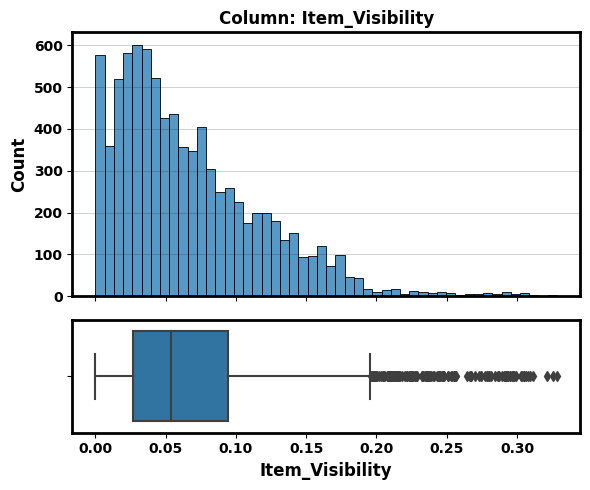

- NaN's Found: 0 (0.0%)
- Unique Values: 7880
- Most common value: '0.0' occurs 526 times (6.17%)
- Not constant or quasi-constant.


In [ ]:
# run the appropriate explore function (based on feature's dtype)
explore_numeric(df_sp,feature);

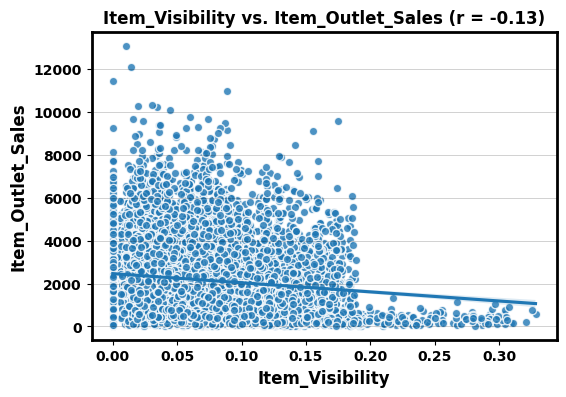

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df_sp, feature, 'Item_Outlet_Sales');

- Feature vs. Target Observations:

  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes, to get ann idea of where items are placed in the stores.

  - Does this feature appear to be a predictor of the target?
    - Yes, downward trend items with more visablity generate less sales

#### Item_Type                  
- The category to which the product belongs

In [ ]:
# Confirming the dtype to select correct EDA function
feature = 'Item_Type'
df_sp[feature].dtype

dtype('O')

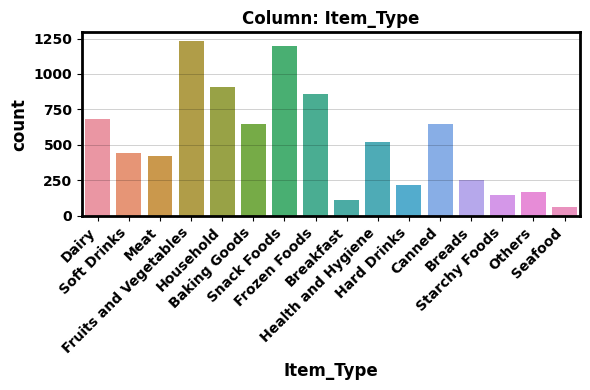

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


In [ ]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df_sp,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

  -0

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 16 unique categories.
  - high cardinality

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



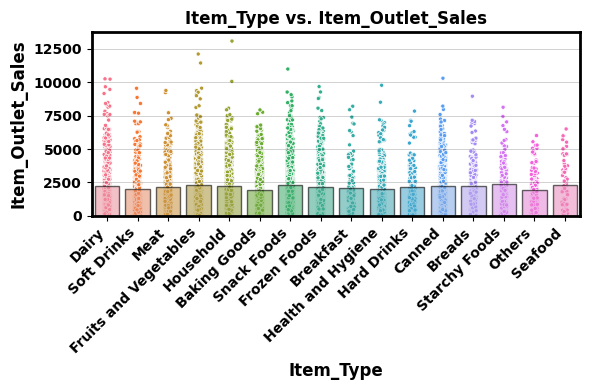

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df_sp, feature, 'Item_Outlet_Sales');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes.
  - Does this feature appear to be a predictor of the target?
    - Yes it does, there is variability between the groups, we can also see that sales are near even across.


#### Item_MRP                   
- 	Maximum Retail Price (list price) of the product

In [ ]:
# Confirming the dtype to select correct EDA function
feature = 'Item_MRP'
df_sp[feature].dtype

dtype('float64')

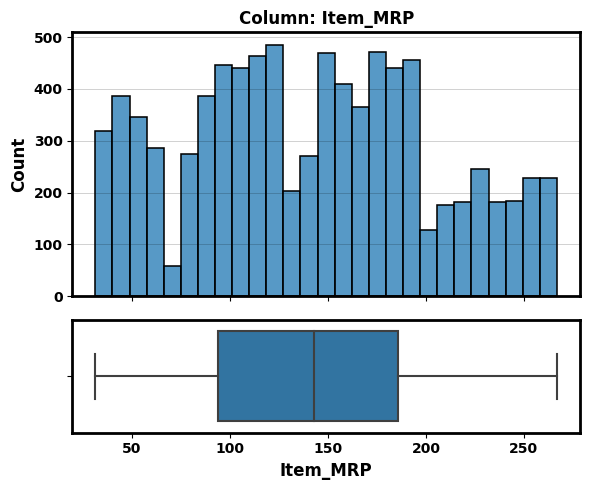

- NaN's Found: 0 (0.0%)
- Unique Values: 5938
- Most common value: '172.0422' occurs 7 times (0.08%)
- Not constant or quasi-constant.


In [ ]:
# run the appropriate explore function (based on feature's dtype)
explore_numeric(df_sp,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 5 (6.49%)
  - impute with median.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



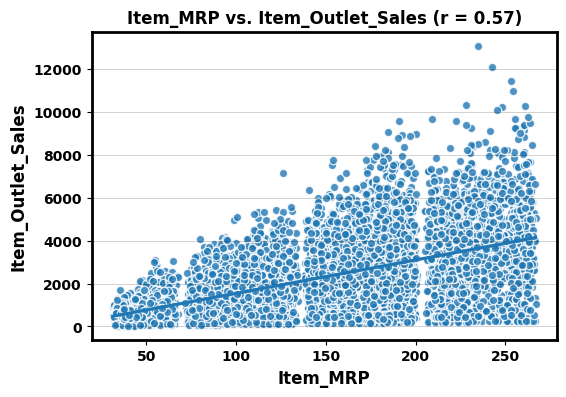

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df_sp, feature, 'Item_Outlet_Sales');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes, shows aveage sales for items .
  - Does this feature appear to be a predictor of the target?
    - Yes,postive correlation with mrp and high sales

___

#### Outlet_Identifier          
- Store ID

In [ ]:
# Confirming the dtype to select correct EDA function
feature = 'Outlet_Identifier'
df_sp[feature].dtype

dtype('O')

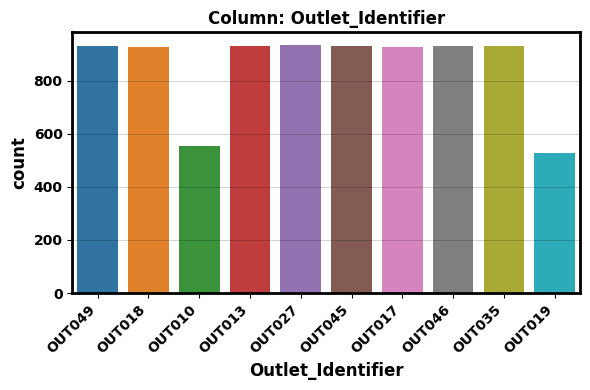

- NaN's Found: 0 (0.0%)
- Unique Values: 10
- Most common value: 'OUT027' occurs 935 times (10.97%)
- Not constant or quasi-constant.


In [ ]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df_sp,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0
3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 10 high.

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



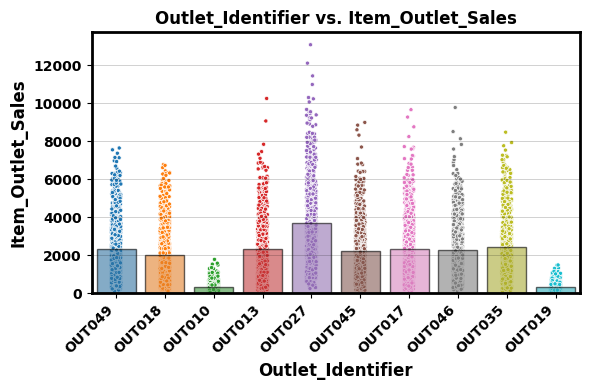

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df_sp, feature, 'Item_Outlet_Sales');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes, how much each outlet is geneatering.
  - Does this feature appear to be a predictor of the target?
    - Yes, shows us where most of the sales are generated.


#### Outlet_Size                
- The size of the store in terms of ground area covered

In [ ]:
# Confirming the dtype to select correct EDA function
feature = 'Outlet_Size'
df_sp[feature].dtype

dtype('O')

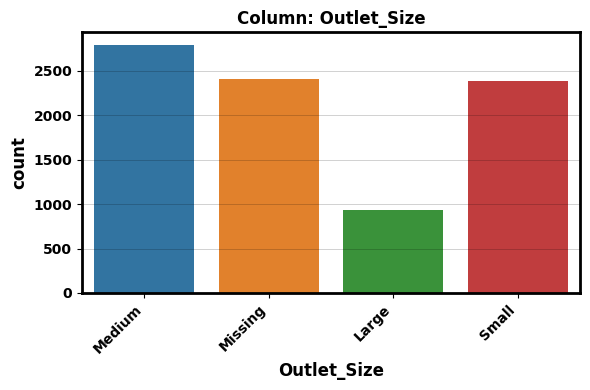

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


In [ ]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df_sp,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 4 unique values ( low).

5. Would we know this BEFORE the target is determined?
  - yes

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



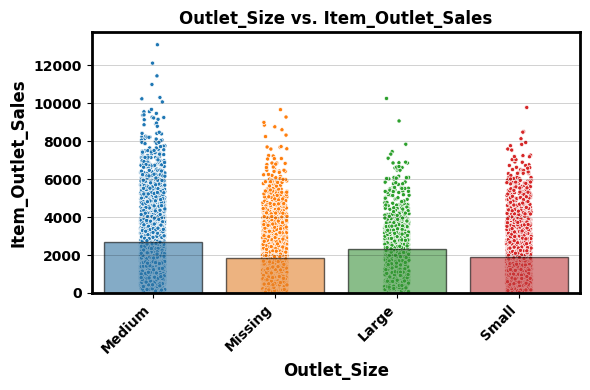

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df_sp, feature, 'Item_Outlet_Sales');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes, showing medium is geneatering the most.
  - Does this feature appear to be a predictor of the target?
    - Yes,

#### Outlet_Location_Type       
- The type of area in which the store is located

In [ ]:
feature = 'Outlet_Location_Type'
df_sp[feature].dtype

dtype('O')

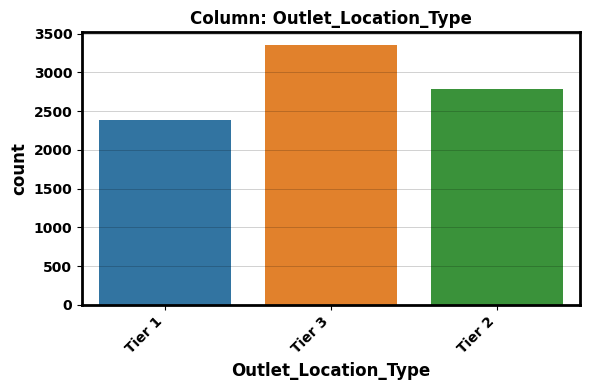

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Tier 3' occurs 3350 times (39.31%)
- Not constant or quasi-constant.


In [ ]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df_sp,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0

3. Is the feature constant or quasi-constant?
  - None.

4. What is the cardinality? Is it high?
  - 3 (very low)

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



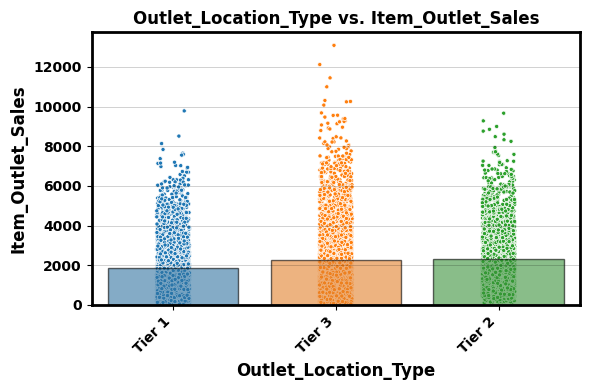

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df_sp, feature, 'Item_Outlet_Sales');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes .
  - Does this feature appear to be a predictor of the target?
    - Yes, It shows sales vs various location helps to show were we should foucs.

#### Outlet_Type                
- 	Whether the outlet is a grocery store or some sort of supermarket

In [ ]:
feature = 'Outlet_Type'
df_sp[feature].dtype

dtype('O')

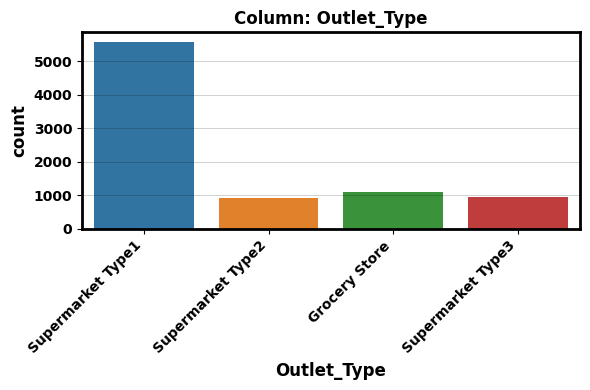

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Supermarket Type1' occurs 5577 times (65.43%)
- Not constant or quasi-constant.


In [ ]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df_sp,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable, numeric.


5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



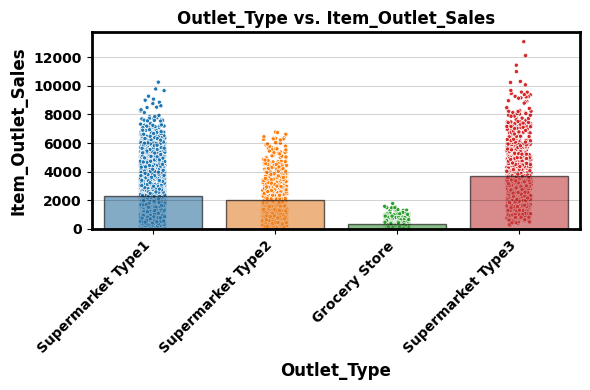

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df_sp, feature, 'Item_Outlet_Sales');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Maybe.
  - Does this feature appear to be a predictor of the target?
    - Yes, It shows while most of our supermarkets are type_1 the sales are balanced across the makerts.


#### Item_Outlet_Sales (Target)        
- 	Sales of the product in the particular store. This is the target variable to be predicted.

In [ ]:
feature = 'Item_Outlet_Sales'
df_sp[feature].dtype

dtype('float64')

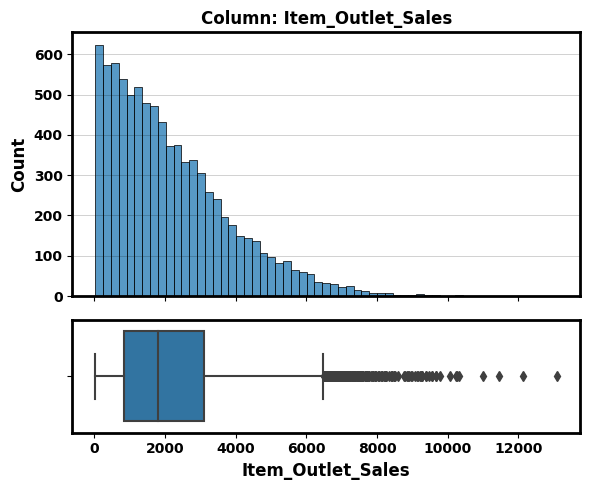

- NaN's Found: 0 (0.0%)
- Unique Values: 3493
- Most common value: '958.752' occurs 17 times (0.2%)
- Not constant or quasi-constant.


In [ ]:
# run the appropriate explore function (based on feature's dtype)
explore_numeric(df_sp,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric.

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not applicable (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes it is our target.

6. Is there a business case/understanding reason to exclude based on our business case?
  - Yes it is our target.


 ### Split data

 Perform a train test split

Create a preprocessing object to prepare the dataset for Machine Learning

Make sure your imputation of missing values occurs after the train test split using SimpleImputer.

Identify the features (X) and target (y): Assign the "Item_Outlet_Sales" column as your target and the rest of the relevant variables as your features matrix.

In [ ]:
# target trying to predict
y = df_sp["Item_Outlet_Sales"]
#The features we would use to make the prediction
x = df_sp.drop(columns = "Item_Outlet_Sales")

### Impute values

Categorical Col

In [ ]:
# Instantaite and fit the imputer for categorical features
impute_missing = SimpleImputer(strategy='constant', fill_value='MISSING')
impute_missing.fit(X_train[cat_col])

SimpleImputer(fill_value='MISSING', strategy='constant')

In [ ]:
# Transform the training and test categorical features and save as new vars
X_train_cat_imputed = impute_missing.transform(X_train[cat_col])
X_test_cat_imputed = impute_missing.transform(X_test[cat_col])

# confirm no null values remaining
X_train_cat_imputed.isna().sum()

Item_Fat_Content        0
Item_Type               0
Outlet_Identifier       0
Outlet_Location_Type    0
Outlet_Type             0
dtype: int64

Ordinal Col

In [ ]:
# Instantaite and fit the imputer for categorical features
impute_most_freq = SimpleImputer(strategy= 'most_frequent', fill_value='Missing')
impute_most_freq.fit(X_train[ord_cols])


SimpleImputer(fill_value='Missing', strategy='most_frequent')

In [ ]:
# Transform the training and test categorical features and save as new vars
X_train_ord_imputed = impute_most_freq.transform(X_train[ord_cols])
X_test_ord_imputed = impute_most_freq.transform(X_test[ord_cols])

# confirm no null values remaining
X_train_ord_imputed.isna().sum()

Outlet_Size    0
dtype: int64

Numeric

In [ ]:
# Get the list of numeric column names
num_cols= X_train.select_dtypes("number").columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')

In [ ]:
# Instantiate the imputer object from the SimpleImputer class with strategy 'median'
impute_median = SimpleImputer(strategy='median')
impute_median.fit(X_train[num_cols])

SimpleImputer(strategy='median')

In [ ]:
X_train_num_imputed = impute_median.transform(X_train[num_cols])
X_train_num_imputed

,Item_Weight,Item_Visibility,Item_MRP
4776,16.350,0.029565,256.4646
7510,15.250,0.000000,179.7660
5828,12.350,0.158716,157.2946
5327,7.975,0.014628,82.3250
4810,19.350,0.016645,120.9098
...,...,...,...
5734,9.395,0.286345,139.1838
5191,15.600,0.117575,75.6670
5390,17.600,0.018944,237.3590
860,20.350,0.054363,117.9466


#### Define target and features and train-test-split:

In [ ]:
# Train test split
X_train,X_test,y_train,y_test = train_test_split(x,y,random_state=42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,OUT018,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,OUT049,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,Missing,Tier 2,Supermarket Type1


In [ ]:
df_sp['Outlet_Size'].unique()

array(['Medium', 'Missing', 'Large', 'Small'], dtype=object)

In [ ]:
# Prepare ordinal pipeline
ord_cols = ['Outlet_Size']

# Impute Most common
impute_common = SimpleImputer(strategy='most_frequent', fill_value= 'Missing')

# Ordinal Encoder
outlet_Size_order = ['Small','Medium','Large']
ord_encoder = OrdinalEncoder(categories = [outlet_Size_order])

# Scaler
scaler = StandardScaler()

# make a pipeline
ord_pipe = make_pipeline(impute_common, ord_encoder, scaler)
ord_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Missing', strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])),
                ('standardscaler', StandardScaler())])

In [ ]:
# Making an ordinal_tuple for ColumnTransformer
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='Missing', strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

In [ ]:
# Prepare Categorical pipeline
cat_col = X_train.select_dtypes('object').drop(columns=ord_cols).columns

impute_missing = SimpleImputer(strategy='constant',fill_value='Missing')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(impute_missing, ohe_encoder)
ohe_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Missing', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [ ]:
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, cat_col)
ohe_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='Missing', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Location_Type', 'Outlet_Type'],
       dtype='object'))

In [ ]:
# Prepare numeric piepline
num_cols = X_train.select_dtypes('number').columns

mean_imputer = SimpleImputer(strategy="median" ,fill_value= -1)
scaler = StandardScaler()

#Numeric Pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value=-1, strategy='median')),
                ('standardscaler', StandardScaler())])

In [ ]:
num_tuple = ('numeric', numeric_pipe ,num_cols)

In [ ]:
# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, ohe_tuple, ord_tuple],
                                    verbose_feature_names_out=False)

In [ ]:
# Fit on training data
col_transformer.fit(X_train)

ValueError: ignored

In [ ]:
# Transform the training data
X_train_processed = col_transformer.transform(X_train)
# Transform the testing data
X_test_processed = col_transformer.transform(X_test)
# View the processed training data
X_train_processed.head()

## Explanatory Data Analysis

